In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
customers = pd.read_csv('/content/drive/MyDrive/Cours/Projet 6/notebook/customers.csv')
products = pd.read_csv('/content/drive/MyDrive/Cours/Projet 6/notebook/products.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Cours/Projet 6/notebook/transactions.csv') 

# Exploration et nettoyage des données

Le but de cette partie est de vérifier que les données sont exploitables et corriger/compléter/supprimer les données erronées/manquantes.

## DF Customers

In [3]:
customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


Le df contient 3 colonnes : 
- colonne 'client_id' : permet d'identifier le client: 
  - chaque id doit être unique;
  - aucun id ne doit être Nan.
- colonne 'sex':
  - a priori ne peut contenir que deux valeurs :'f' ou 'm'
  - ne devrait pas contenir de valeurs nulles (si le nombre est faible cela ne devrait pas pour autant gêner les calculs.)
- colonne 'birth':
  - il convient de vérifier s'il n'y a pas un trop grand nombre de valeurs nulles qui pourrait fausser les calculs.
  - vérifier qu'il n'y a pas de valeurs aberrantes.

L'ensemble de ces élément va être vérifié point par point:

In [4]:
# Vérification du type de données et de l'absence de Nan
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


Le fichier ne contient pas de Nan

In [5]:
customers.describe()

,birth
count,8623.000000
mean,1978.280877
std,16.919535
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


Le client le plus agé est né en 1929 et le moins agé en 2004. Ces valeurs ne sont pas aberrantes.

In [6]:
customers['sex'].unique()

array(['f', 'm'], dtype=object)

Il n'y a pas de valeurs autre que 'f' ou 'm' dans la colonne 'sex' donc pas d'erreurs a priori.

In [7]:
customers['client_id'].nunique()

8623

Il n'y a pas d'id dupliqué.

La colonne 'birth' va être transformée pour indiquer l'âge du client, pour plus de lisibilité" et être transformée en "object" pour éviter les itérations dessus.

In [8]:
customers['age'] = 2022 - customers['birth']

In [9]:
customers['age'] =customers['age'].astype('object') 

In [10]:
customers.drop(columns = {'birth'}, inplace= True)

Conclusion: le fichier customers ne contient pas d'erreur et peut être utilisé tel quel.

In [11]:
customers= customers.copy()

### Regroupement par catégorie d'âge

In [12]:
customers['age'].max()-customers['age'].min()

75

L'âge de la clientèle s'étale sur 75 années, c'est trop pour pouvoir étudier leur comportement en fonction de cette variable, il faut donc le réduire.

Nous allons réaliser une segmentation par quantile et non par tranche d'âge, en effet, celà permettra d'avoir une analyse fine sur les tranches d'âges les plus représentées dans la clientèle et une analyse plus macro sur les catégories les moins représentées.

20 segments seront créés afin de conserver une analyse fine mais lisible

In [13]:
customers['segment'] = pd.qcut(customers['age'],20, duplicates ='drop')

## DF products

In [14]:
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [15]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


Le DF products ne contient pas de Nan en revanche la colonne 'categ' est paramétrée en 'int64' et non en 'category'

In [16]:
products['categ'] = products['categ'].astype('category')

In [17]:
products['id_prod'].nunique()

3287

Il n'y a pas de doublons dans les id.

In [18]:
products.describe()

,price
count,3287.000000
mean,21.856641
std,29.847908
min,-1.000000
25%,6.990000
50%,13.060000
75%,22.990000
max,300.000000


Il semble qu'il y ait des outliers dans le colonne prix un DF temporaire va être créé pour les détecter et éventuellement les supprimer.

In [19]:
outliers = products.copy()

In [20]:
outliers['zscore'] = (outliers['price'] - outliers['price'].mean())/outliers['price'].std()

In [21]:
outliers = outliers.loc[outliers['zscore']>3]

In [22]:
outliers.sort_values('price')

,id_prod,price,categ,zscore
1464,2_60,111.72,2,3.010709
2398,2_169,111.99,2,3.019755
2155,2_73,111.99,2,3.019755
241,2_231,111.99,2,3.019755
2939,2_161,113.99,2,3.086761
...,...,...,...,...
2779,2_30,233.54,2,7.092067
1436,2_167,236.99,2,7.207653
394,2_158,247.22,2,7.550391
724,2_76,254.44,2,7.792284


Ces valeurs sont élevées mais ne semblent pas aberrantes. Elle ne seront pas supprimées même s'il peut être intéressant de vérifier s'il ne s'agit pas d'erreurs.

In [23]:
products.loc[products['price']<=0]

,id_prod,price,categ
731,T_0,-1.0,0


Un produti a un prix negatif. Cette donnée est a confirmer également même s'il est possible qu'il s'agisse par exemple de la référence d'une réduction ou un code produit permettant d'effectuer les remboursements. 
Il ne vaut mieux pas la supprimer pour éviter de fausser le calcul du chiffre d'affaire.

CONCLUSION: le df 'products' parait utilisable sans opérations supplémentaires.

## DF transcations

In [24]:
transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [25]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


Le DF 'transactions' ne contient pas de valeurs nulles.
En revanche il convient de modifier le format de la colonne 'date' qui est en 'object' et non au format 'datetime'. (fait au moment de l'importation du fichier)

In [26]:
transactions['date'] = pd.to_datetime(transactions['date'], format="%Y-%m-%d %H:%M:%S.%f", errors='coerce')

In [27]:
transactions.sort_values('date')

,id_prod,date,session_id,client_id
480642,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
428477,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
462702,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
488300,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
439073,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033
...,...,...,...,...
657830,T_0,NaT,s_0,ct_0
662081,T_0,NaT,s_0,ct_1
670680,T_0,NaT,s_0,ct_1
671647,T_0,NaT,s_0,ct_1


Suite à cette opération, il apparaît que des lignes de test ont été introduites dans les transactions.

In [28]:
test = transactions.loc[transactions['date'].isna(),:]

In [29]:
test['id_prod'].unique()

array(['T_0'], dtype=object)

In [30]:
test['client_id'].unique()

array(['ct_0', 'ct_1'], dtype=object)

In [31]:
test['session_id'].unique()

array(['s_0'], dtype=object)

C'est lignes de test ne comportent pas de date, un numéro de session égal à s_0, concernent le produit T_0 et les clients ct_1 et ct_0. L'ensemble de ces données vont êtres supprimées du DF 'transactions', la jointure se fera par une liaision à gauche, sur le DF "transactions" ce qui permettra de ne plus conservées dans les données finales les clients ct_1 et ct_0, le produit T_0 et la session s_0. 

In [32]:
liste = test.index
transactions.drop(liste, inplace = True)
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 25.9+ MB


# Regroupement des données

Ici la fusion à gauche et choisie entre le fichier 'transaction' et 'products' afin, le cas échéant, de pouvoir isoler les transactions pour lesquelles le produit acheté n'est pas référencé. On procédera de même avec le DF nouvellement créé et 'customers'.

In [33]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 25.9+ MB


In [34]:
data = transactions.merge(products, how = 'left')

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679331
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
 4   price       679111 non-null  float64       
 5   categ       679111 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), object(3)
memory usage: 31.7+ MB


In [36]:
data = data.merge(customers, how='left')

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679331
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
 4   price       679111 non-null  float64       
 5   categ       679111 non-null  category      
 6   sex         679332 non-null  object        
 7   age         679332 non-null  object        
 8   segment     679332 non-null  category      
dtypes: category(2), datetime64[ns](1), float64(1), object(5)
memory usage: 42.8+ MB


En comparant le nombre de valeurs non-null par colonnes on se rend compte que pour certaines transactions le produits n'est pas connus.

In [38]:
données_manquantes = data.loc[data['price'].isna()]

In [39]:
données_manquantes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 2633 to 677797
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id_prod     221 non-null    object        
 1   date        221 non-null    datetime64[ns]
 2   session_id  221 non-null    object        
 3   client_id   221 non-null    object        
 4   price       0 non-null      float64       
 5   categ       0 non-null      category      
 6   sex         221 non-null    object        
 7   age         221 non-null    object        
 8   segment     221 non-null    category      
dtypes: category(2), datetime64[ns](1), float64(1), object(5)
memory usage: 15.2+ KB


In [40]:
données_manquantes['id_prod'].unique()

array(['0_2245'], dtype=object)

Ces données manquantes viennent d'un produit qui n'est pas référencé dans le DF "products", mais on peut déjà constater que ce produit appartient à la catégorie 0 et compte tenu du faible nombre drinformation manquantes par rapport au nombre total de lignes de 'data', on peut considérer qu'une imputation par la moyenne permettra de fournir une bonne approximation.

In [41]:
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [42]:
# Compléter la colonne catégorie de "données_manquantes" 
données_manquantes['categ'] = products.iloc[0,2]

<ipython-input-42-fa4445546834>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  données_manquantes['categ'] = products.iloc[0,2]


In [43]:
# Compléter la colonne 'price' de "données_manquantes" 
données_manquantes['price'] = round(products.loc[products['categ'] ==0 ,"price"].mean(),2)

<ipython-input-43-a493a90da369>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  données_manquantes['price'] = round(products.loc[products['categ'] ==0 ,"price"].mean(),2)


In [44]:
données_manquantes.head()

,id_prod,date,session_id,client_id,price,categ,sex,age,segment
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,11.73,0,m,82,"(73.0, 93.0]"
10103,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,11.73,0,f,59,"(56.0, 59.0]"
11723,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,11.73,0,m,44,"(43.0, 45.0]"
15670,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,11.73,0,m,31,"(30.0, 33.0]"
16372,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,11.73,0,m,49,"(47.0, 50.0]"


In [45]:
# Compléter 'data' avec les nouvelles données
data.update(données_manquantes)

In [46]:
# Vérification:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679331
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype                   
---  ------      --------------   -----                   
 0   id_prod     679332 non-null  object                  
 1   date        679332 non-null  datetime64[ns]          
 2   session_id  679332 non-null  object                  
 3   client_id   679332 non-null  object                  
 4   price       679332 non-null  float64                 
 5   categ       679332 non-null  float64                 
 6   sex         679332 non-null  object                  
 7   age         679332 non-null  object                  
 8   segment     679332 non-null  interval[float64, right]
dtypes: datetime64[ns](1), float64(2), interval(1), object(5)
memory usage: 57.0+ MB


In [47]:
# Vérification:
data.loc[data['id_prod'] == '0_2245' ,:]

,id_prod,date,session_id,client_id,price,categ,sex,age,segment
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,11.73,0.0,m,82,"(73.0, 93.0]"
10103,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,11.73,0.0,f,59,"(56.0, 59.0]"
11723,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,11.73,0.0,m,44,"(43.0, 45.0]"
15670,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,11.73,0.0,m,31,"(30.0, 33.0]"
16372,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,11.73,0.0,m,49,"(47.0, 50.0]"
...,...,...,...,...,...,...,...,...,...
669533,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131,11.73,0.0,m,41,"(40.0, 43.0]"
670484,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167,11.73,0.0,f,43,"(40.0, 43.0]"
671088,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453,11.73,0.0,m,41,"(40.0, 43.0]"
675480,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098,11.73,0.0,m,36,"(35.0, 38.0]"


Les analyses demandées ne nécessitent pas un suivi temporel très précis. Seule la date sera donc conservée dans la colonne 'date' pour faciliter les aggrégations.

In [48]:
# Transformation de la date au format AAAA-MM-JJ
data['date'] = pd.to_datetime(data['date']).dt.date

# Analyse des données

Le DF "data" regroupe par date chaque achat réalisé par chaque client. Selon les données que l'on souhaite observer, il faut réaliser des regroupements. A DF spécifique sera donc créé pour chaque partie à partir du DF "data" pour limiter le risques d'erreurs/pertes de données.

## Top et Flop

In [49]:
# Création du DF avec le nombre de vente et le chiffre d'affaire total par produit
vente = data.copy()
vente = vente.groupby('id_prod').agg({'id_prod':'count','price':'sum'})
vente = vente.rename(columns = {'id_prod':'nb_ventes','price':'ca'})
vente = vente.reset_index()

In [50]:
vente['prix_unitaire']=vente['ca']/vente['nb_ventes']

Ici le but est de déterminer quels sont les produits qui se vendent le mieux et ceux qui se vendent le moins bien. Pour cela il est possible de considérer deux métriques : 
- le chiffre d'affaire;
- le nombre de vente.

In [51]:
# Classement par chiffre d'affaire
vente.sort_values('ca',ascending = False)

,id_prod,nb_ventes,ca,prix_unitaire
3097,2_159,650,94893.50,145.99
3071,2_135,1005,69334.95,68.99
3046,2_112,968,65407.76,67.57
3035,2_102,1027,60736.78,59.14
3153,2_209,814,56971.86,69.99
...,...,...,...,...
665,0_1601,1,1.99,1.99
2080,0_807,1,1.99,1.99
719,0_1653,2,1.98,0.99
313,0_1284,1,1.38,1.38


In [52]:
# Classement par nombre de ventes
vente.sort_values('nb_ventes', ascending = False)

,id_prod,nb_ventes,ca,prix_unitaire
2592,1_369,2252,54025.48,23.99
2645,1_417,2189,45947.11,20.99
2642,1_414,2180,51949.40,23.83
2734,1_498,2128,49731.36,23.37
2654,1_425,2096,35611.04,16.99
...,...,...,...,...
313,0_1284,1,1.38,1.38
1793,0_549,1,2.99,2.99
549,0_1498,1,2.48,2.48
1785,0_541,1,1.99,1.99


On constate que pour certains produits une seule vente a été réalisée, mais étant donné que DF 'data' ne fait état que des ventes réalisées, il n'inclus pas les produits qui n'ont jamais été vendus.

In [53]:
# Comparer le nombre d'id_prod dans 'data' et 'products' pour déterminer s'il y a effectivement des produits qui n'ont pas été vendus
liste = data['id_prod'].unique()
liste_2 = products['id_prod'].unique()
print('Il y a',len(liste_2)-len(liste),"références de produits qui n'ont pas été vendus une seule fois")

Il y a 21 références de produits qui n'ont pas été vendus une seule fois


In [54]:
# Recherche des id_produits n'apparaissant pas dans le DF 'data'
liste_3 = []
for i in liste_2:
  if i in liste:
    pass
  else:
    liste_3.append(i)
produits_non_vendus = products.iloc[:0,]

# Création du DF regroupant les produits non vendus
for i in liste_3:
  x = products.loc[products['id_prod']==i,:]
  produits_non_vendus = pd.concat([produits_non_vendus,x])

In [55]:
produits_non_vendus.head()

,id_prod,price,categ
184,0_1016,35.06,0
279,0_1780,1.67,0
731,T_0,-1.00,0
737,0_1062,20.08,0
794,0_1119,2.99,0


## Analyse prix par catégorie

Dans le DF "products" nous nous sommes aperçu qu'un produit "test" avait été introduit le "T_0" il convient de le supprimer pour analyser les prix des produits.

In [56]:
liste = products.loc[products['id_prod']== "T_0"].index
products.drop(liste, inplace = True)

Comptage du nombre de produits par catégorie:

In [57]:
products['categ'].value_counts()

0    2308
1     739
2     239
Name: categ, dtype: int64

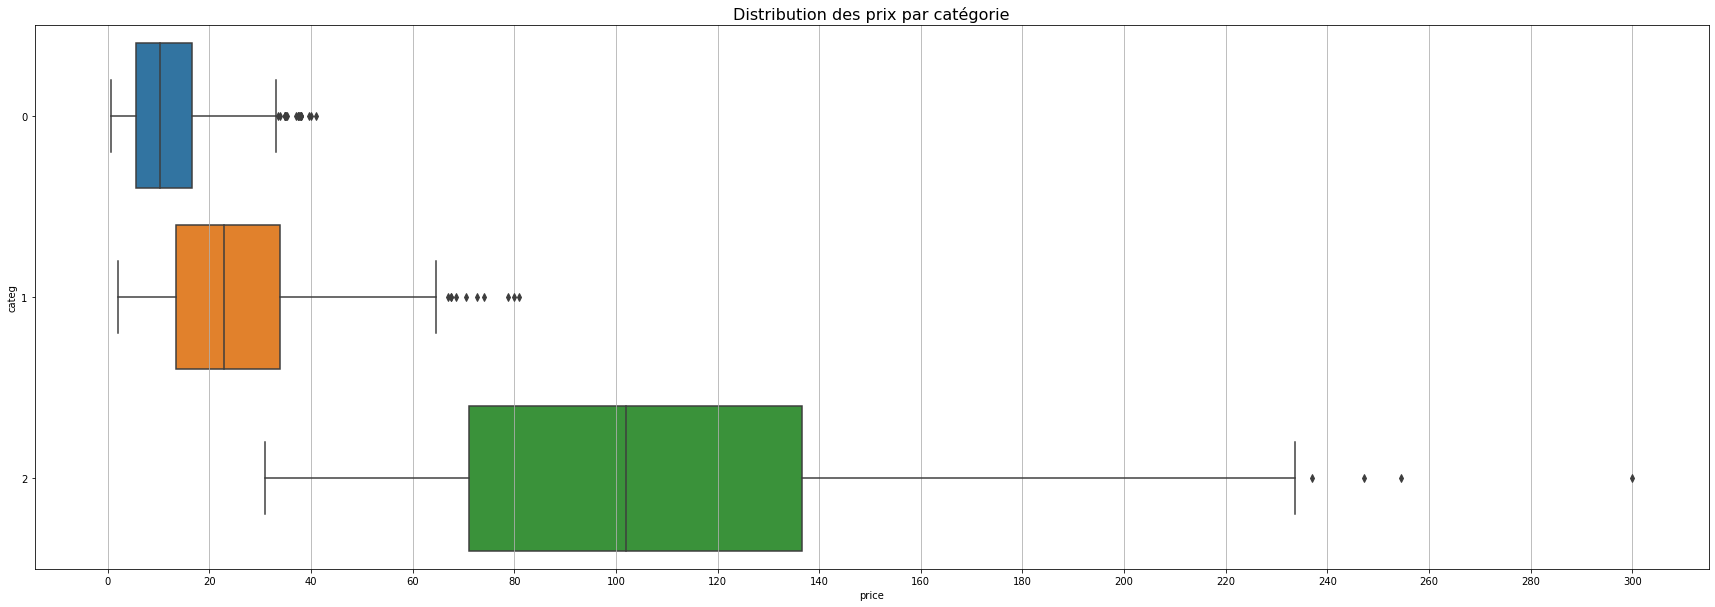

In [58]:
plt.figure(figsize=(30,10))
sns.boxplot(data = products, y='categ', x= 'price', orient='h')
plt.grid(axis="x")
plt.xticks(range(0,round(products['price'].max()+20),20))
plt.title('Distribution des prix par catégorie', fontsize = 16)
plt.show()

On constate que:
- la catégorie 0 comprend de nombreux produits à des prix globalement peu cher.
- la catégorie 1 contient un nombre "intermédiaire" de produit à des prix globalement "intermédiaires".
- la catégorie 2 contient peu de produits à des prix globalement "élevés".

## Analyse du chiffre d'affaire par categorie

Ici nous allons observer la répartition du chiffre d'affaire par catégorie à l'aide d'un graphique:

In [59]:
# Creation du DF
categorie = data.groupby(['categ'])['price'].sum().reset_index().copy()
categorie = categorie.rename(columns={"price": "ca"})

In [60]:
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n{:,} €".format(pct, absolute)

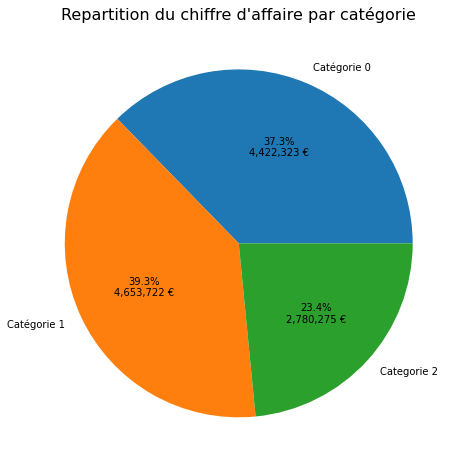

In [61]:
plt.figure(figsize = (8,8))
plt.pie(data = categorie, x='ca', autopct = lambda pct : func(pct, categorie['ca']), labels = ['Catégorie 0','Catégorie 1', 'Categorie 2'])
plt.title("Repartition du chiffre d'affaire par catégorie", fontsize = 16)
plt.show()

In [62]:
print("Le chiffre d'affaire total de la boutique en ligne est de", "{:,.2f} €".format(categorie['ca'].sum()))

Le chiffre d'affaire total de la boutique en ligne est de 11,856,321.01 €


## Analyse dans le temps

Ici nous allons observer les variations journalières du chiffre d'affaire

In [63]:
# Création du DF
daily = data.groupby(['date'],as_index = False)['price'].sum()
daily = daily.rename(columns={'price':'ca'})
daily = daily.set_index(pd.DatetimeIndex(daily['date']))
daily.drop(columns ='date', inplace = True)
daily['ca_cumul'] = daily['ca'].cumsum(axis=0)

In [64]:
daily.head()

,ca,ca_cumul
date,,
2021-03-01,16576.95,16576.95
2021-03-02,15498.18,32075.13
2021-03-03,15198.69,47273.82
2021-03-04,15196.07,62469.89
2021-03-05,17471.37,79941.26


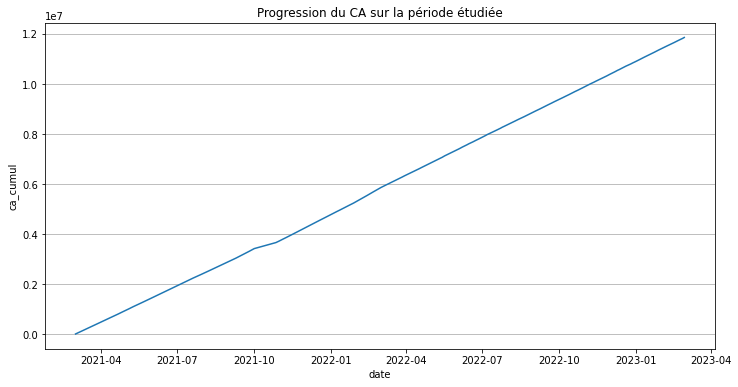

In [65]:
plt.figure(figsize=(12,6))
sns.lineplot(data=daily['ca_cumul'])
plt.title('Progression du CA sur la période étudiée')
plt.grid(axis='y')
plt.show()

La progression du CA semble constante sur la période étudiée. Nous allons maintenant regarder plus en détail ses variations périodiques:

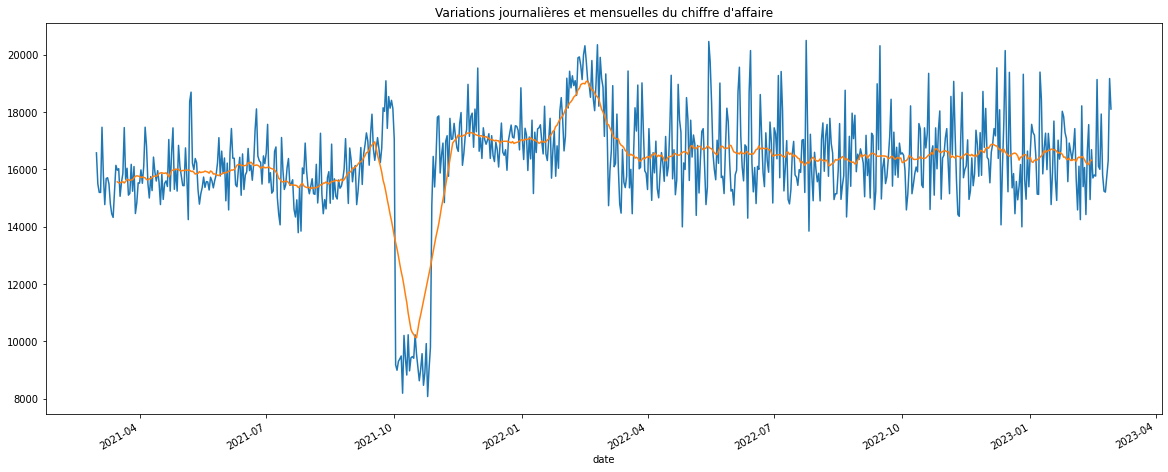

In [66]:
plt.figure(figsize=(20,8))
plt.plot(daily.index, daily['ca'])
daily['ca'].rolling(window=30, center = True).mean().plot()
plt.title("Variations journalières et mensuelles du chiffre d'affaire")
plt.show()

On observe sur ce graphique que le chiffre d'affaire journalier varie fortement mais que le chiffre d'affaire mensuel lui reste plutôt stable, ormis en octobre 2021 et mars 2022.

Nous allons visualiser l'évolution du chiffre d'affaire par catégorie pour voir s'il est possible de déterminer d'où viennent les deux fortes variations constatées sur le graphique.

In [67]:
# Création du DF
ca_categ = data.groupby(['date', 'categ'],as_index = False)['price'].sum()
ca_categ = ca_categ.rename(columns={'price':'ca'})
ca_categ = ca_categ.pivot_table(values='ca', index = 'date',columns='categ')

In [68]:
ca_categ.index = pd.to_datetime(ca_categ.index)

In [69]:
ca_categ.head()

categ,0.0,1.0,2.0
date,,,
2021-03-01,6274.38,6811.53,3491.04
2021-03-02,6730.00,5627.15,3141.03
2021-03-03,6121.03,5691.41,3386.25
2021-03-04,5891.48,6098.98,3205.61
2021-03-05,5975.97,7071.21,4424.19


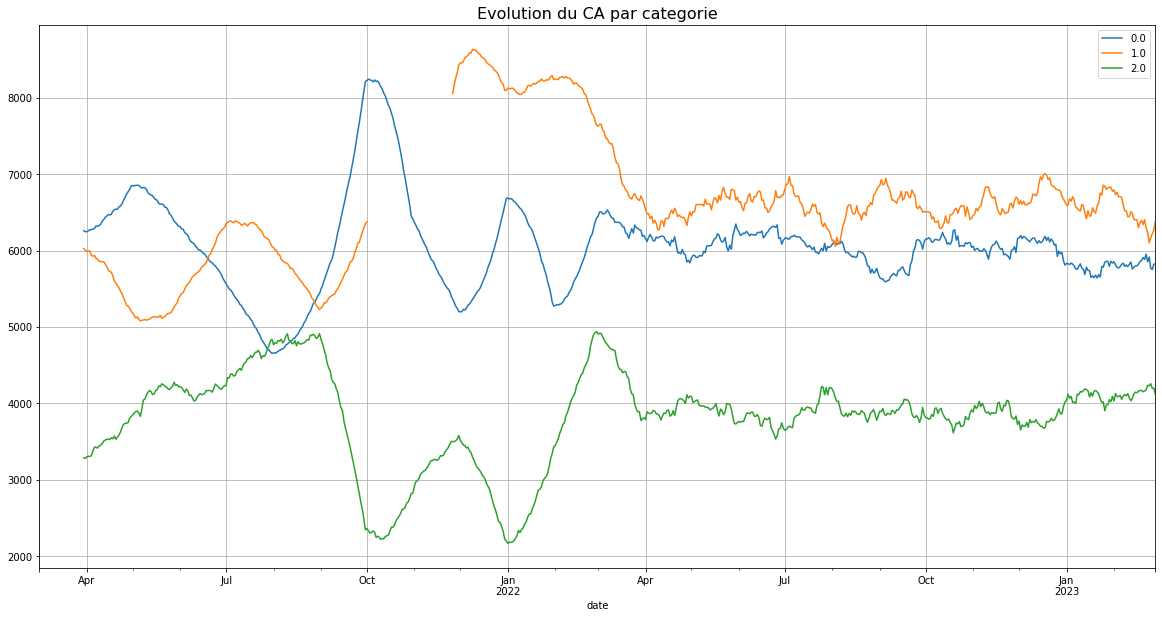

In [70]:
x = 30
plt.figure(figsize=(20,10))
ca_categ[0].rolling(window=x).mean().plot()
ca_categ[1].rolling(window=x).mean().plot()
ca_categ[2].rolling(window=x).mean().plot()
plt.grid()
plt.title(label='Evolution du CA par categorie', fontsize = 16)
plt.legend()
plt.show()

Il y a sur la première année des variations brutales du CA en particuliers au dernier trimestre. Il est probable que des données soient manquantes. Nous allons les recherhcer:

In [71]:
ca_categ.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2021-03-01 to 2023-02-28
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0.0     730 non-null    float64
 1   1.0     704 non-null    float64
 2   2.0     730 non-null    float64
dtypes: float64(3)
memory usage: 22.8 KB


In [72]:
temp = ca_categ.loc[ca_categ[1.0].isna(),:]

In [73]:
temp.tail()

categ,0.0,1.0,2.0
date,,,
2021-10-23,5704.26,NaN,3206.38
2021-10-24,6036.65,NaN,3886.54
2021-10-25,5817.82,NaN,2258.22
2021-10-26,6346.74,NaN,2685.78
2021-10-27,5822.24,NaN,3967.29


On constate que pour le mois d'octobre il manque l'ensemble des données pour la catégorie 1. Nous allons inférer par la moyenne pour compléter les données.
 

In [74]:
round(ca_categ[1.0].mean(),2)

6610.4

In [75]:
ca_categ.fillna(round(ca_categ[1.0].mean(),2), inplace =True)

## Nouvelles observations suites au complément de données:

Le complément de données va probablement conduire à un changement des graphiques vu précédemment, nous allons donc les visualiser de nouveaux pour observer ces changements.

In [76]:
ca_categ['ca_total'] = ca_categ[0.0] + ca_categ[1.0]+ ca_categ[2.0]

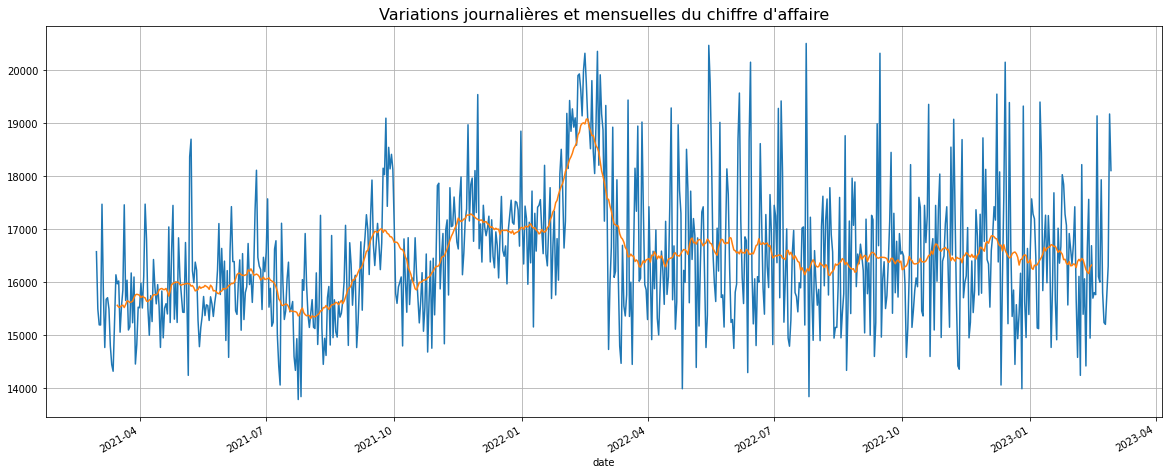

In [77]:
plt.figure(figsize=(20,8))
plt.plot(ca_categ.index, ca_categ['ca_total'])
ca_categ['ca_total'].rolling(window=30, center = True).mean().plot()
plt.title("Variations journalières et mensuelles du chiffre d'affaire" , fontsize = 16)
plt.grid()
plt.show()

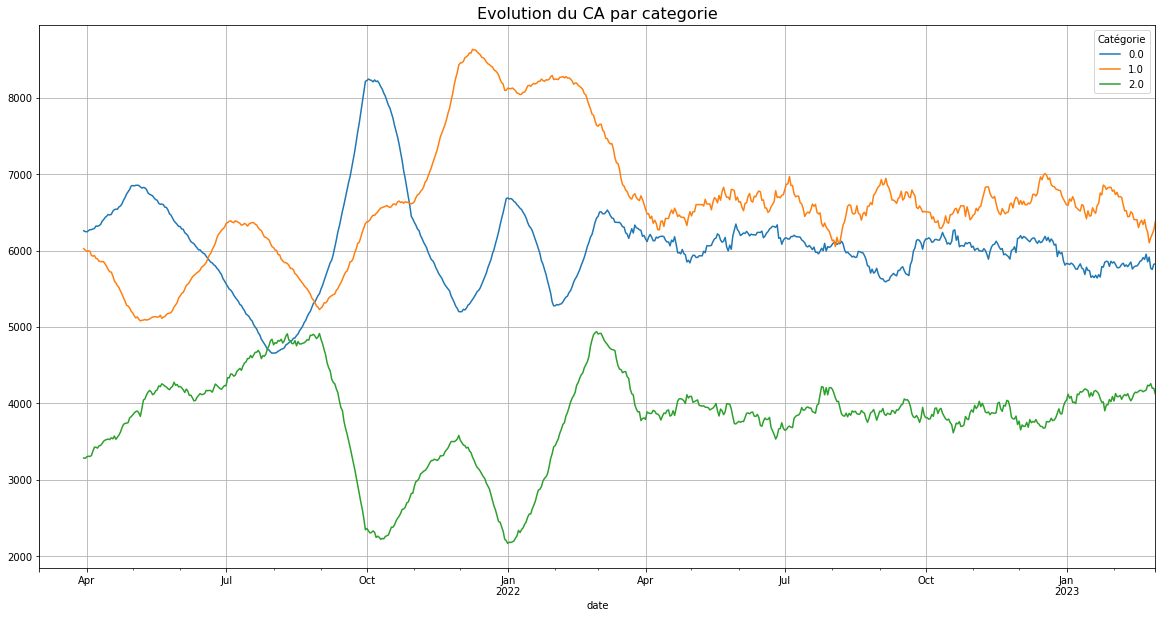

In [78]:
x = 30
plt.figure(figsize=(20,10))
ca_categ[0].rolling(window=x).mean().plot()
ca_categ[1].rolling(window=x).mean().plot()
ca_categ[2].rolling(window=x).mean().plot()
plt.grid()
plt.title(label='Evolution du CA par categorie', fontsize = 16)
plt.legend(title = 'Catégorie')
plt.show()

In [79]:
categorie.head()

,categ,ca
0,0.0,4422323.30
1,1.0,4653722.69
2,2.0,2780275.02


In [80]:
categorie.iloc[1:2,1:2] = ca_categ[1.0].sum()

In [81]:
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n{:,} €".format(pct, absolute)

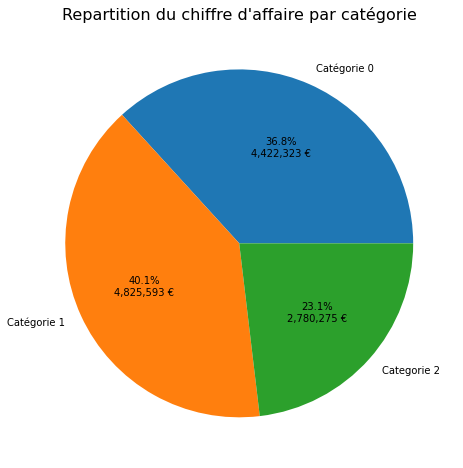

In [82]:
plt.figure(figsize = (8,8))
plt.pie(data = categorie, x='ca', autopct = lambda pct : func(pct, categorie['ca']), labels = ['Catégorie 0','Catégorie 1', 'Categorie 2'])
plt.title("Repartition du chiffre d'affaire par catégorie", fontsize = 16)
plt.show()

## Analyse du comportement des clients

### Courbe de Lorenz

Ici nous allons observer via une courbe de Lorenz, la différence de répartition du chiffre d'affaire entre les clients.

In [83]:
lorenz = data.copy()
lorenz = lorenz.groupby('client_id')['price'].sum().reset_index()
lorenz = lorenz.sort_values('price')

In [84]:
données = np.cumsum(lorenz['price'])/lorenz['price'].sum()
n=len(données)
données = np.append([0],données)
xaxis = np.linspace(0-1/n,1+1/n,n+1)

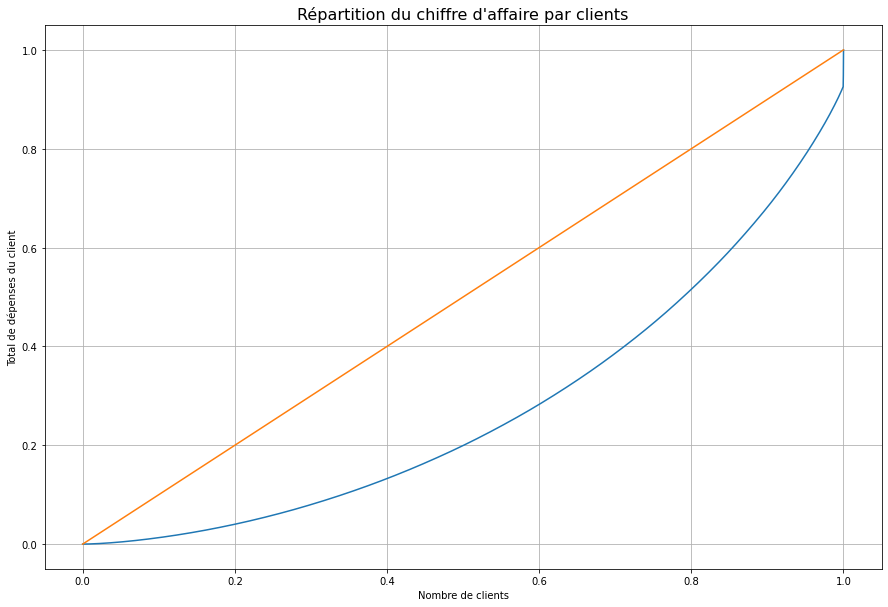

In [85]:
plt.figure(figsize=(15,10))
plt.plot(xaxis,données)
plt.plot([0,1],[0,1])
plt.title("Répartition du chiffre d'affaire par clients", fontsize = 16)
plt.xlabel('Nombre de clients')
plt.ylabel('Total de dépenses du client')
plt.grid()
plt.show()

La pente de la courbe de Lorenz s'accentue brutalement en fin de courbe, il y a donc un déséquilibre important entre quelques "gros acheteurs" et les autres. Il convient de les identifier pour les traiter à part.

### Séparations "clients" et "clients_pro"

Pour réaliser cette séparation il est nécessaire de regarger le montant des achats cumulés par client.

In [86]:
# Création du DF
clients = data.copy()
clients = clients.pivot_table(index = "client_id",columns='categ', values='price', aggfunc= 'sum')
clients = clients.reset_index()

In [87]:
clients.head()

categ,client_id,0.0,1.0,2.0
0,c_1,360.15,143.16,54.87
1,c_10,263.87,809.77,279.96
2,c_100,31.38,84.94,138.53
3,c_1000,386.85,1875.04,NaN
4,c_1001,907.73,605.13,300.00


In [88]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8600 entries, 0 to 8599
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  8600 non-null   object 
 1   0.0        7896 non-null   float64
 2   1.0        8453 non-null   float64
 3   2.0        3597 non-null   float64
dtypes: float64(3), object(1)
memory usage: 268.9+ KB


On constate que certains clients n'ont pas achetés certaines catégorie de livre. Il va falloir remplacer ces valeurs par zéro pour pouvoir réaliser des opérations sur l'ensemble des colonnes.

In [89]:
clients[0.0].fillna(0, inplace=True)
clients[1.0].fillna(0, inplace=True)
clients[2.0].fillna(0, inplace=True)

In [90]:
clients['total'] = clients[0]+clients[1]+clients[2]

In [91]:
clients = clients.sort_values('total')

Nous avons identifier grâce à la courbe de Lorenz que des "outliers" se situent en fin de tableau:

In [92]:
clients.tail(10)

categ,client_id,0.0,1.0,2.0,total
7791,c_8026,3493.77,1600.54,0.00,5094.31
7006,c_7319,2936.17,2175.61,43.99,5155.77
1268,c_2140,3360.28,1702.55,145.99,5208.82
2108,c_2899,25.38,779.01,4409.66,5214.05
634,c_1570,2812.80,2312.83,145.99,5271.62
2513,c_3263,3399.29,1877.58,0.00,5276.87
2724,c_3454,28814.88,83583.02,1275.22,113673.12
6337,c_6714,57324.97,73246.54,23097.79,153669.30
4388,c_4958,48.76,39375.24,250336.34,289760.34
677,c_1609,214447.24,108084.90,1501.21,324033.35


Il y a effectivement 4 clients qui ont des niveaux de dépenses bien plus élevés que les autres. Compte-tenu du niveau de ces dépenses (+100k€ sur deux ans), il semble raisonnable d'estimer qu'il s'agisse de client professionnels que nous allons exclure de l'étude portant sur le comportement des clients car ils risquent de fausser fortement les calculs.

In [93]:
clients_pro = clients.iloc[-4:,:].copy()

In [94]:
liste_pro= clients_pro['client_id'].to_list()

Les "clients professionnels" vont être identifier via leurs client_id dans le DF "data" afin de pouvoir isoler chacunes de leurs transactions, mais aussi pour créer la liste des transactions à supprimer dans le DF "data" pour les prochaines analyses.

In [95]:
# Création du DF regroupant l'ensemble des transactions des "clients professionnels"
ca_pro= data.iloc[:0,:]
for i in liste_pro:
  x = data.loc[data['client_id'] == i,:]
  ca_pro = pd.concat([ca_pro,x])

In [96]:
ca_pro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46643 entries, 145 to 679314
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype                   
---  ------      --------------  -----                   
 0   id_prod     46643 non-null  object                  
 1   date        46643 non-null  object                  
 2   session_id  46643 non-null  object                  
 3   client_id   46643 non-null  object                  
 4   price       46643 non-null  float64                 
 5   categ       46643 non-null  float64                 
 6   sex         46643 non-null  object                  
 7   age         46643 non-null  object                  
 8   segment     46643 non-null  interval[float64, right]
dtypes: float64(2), interval(1), object(6)
memory usage: 3.9+ MB


In [97]:
# création de la liste des transactions à supprimer du DF "data" pour l'étude des "clients particuliers"
liste_index_clients_pro = ca_pro.index.to_list()

In [98]:
len(liste_index_clients_pro)

46643

In [99]:
ca_pro.head()

,id_prod,date,session_id,client_id,price,categ,sex,age,segment
145,1_731,2022-11-12,s_296642,c_3454,11.99,1.0,m,53,"(50.0, 53.0]"
257,1_622,2022-06-11,s_221971,c_3454,17.41,1.0,m,53,"(50.0, 53.0]"
350,0_1280,2023-01-15,s_327467,c_3454,11.96,0.0,m,53,"(50.0, 53.0]"
466,1_285,2021-12-16,s_135210,c_3454,14.99,1.0,m,53,"(50.0, 53.0]"
476,0_1197,2022-06-27,s_230067,c_3454,6.99,0.0,m,53,"(50.0, 53.0]"


### Répartition du chiffre d'affaire clients particuliers / clients professionnels

In [100]:
clients.head()

categ,client_id,0.0,1.0,2.0,total
8151,c_8351,6.31,0.00,0.0,6.31
7918,c_8140,8.30,0.00,0.0,8.30
7889,c_8114,9.98,0.00,0.0,9.98
1556,c_240,0.00,11.06,0.0,11.06
4044,c_4648,0.00,11.20,0.0,11.20


In [101]:
clients['type'] = np.nan

In [102]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8600 entries, 8151 to 677
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  8600 non-null   object 
 1   0.0        8600 non-null   float64
 2   1.0        8600 non-null   float64
 3   2.0        8600 non-null   float64
 4   total      8600 non-null   float64
 5   type       0 non-null      float64
dtypes: float64(5), object(1)
memory usage: 470.3+ KB


Les clients sont classés par dépenses totales, il suffit donc de créer une liste de longueur égale au nombre de client contenant 8596 valeurs 'part' en début de liste et 4 valeurs 'pro' en fin de liste et l'ajouter en tant que colonne au DF.

In [103]:
liste = ['part']*(len(clients['client_id'])-4) +['pro']*4

clients['type'] = liste

Visualisons ces données dans un graphique

In [104]:
temp = clients.groupby('type')['total'].sum().reset_index()

In [105]:
temp.head()

,type,total
0,part,10975184.90
1,pro,881136.11


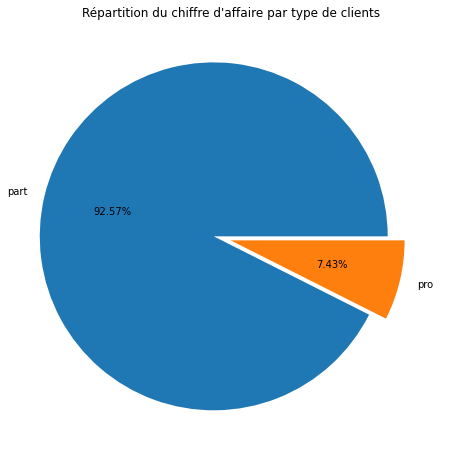

In [106]:
expl= [0.1,0]
plt.figure(figsize = (8,8))
plt.pie(data = temp, x='total', autopct = "%.2f%%", labels= temp['type'].to_list(), explode = expl)
plt.title("Répartition du chiffre d'affaire par type de clients")
plt.show()

## Segmentation de la clientèle

### Analyse des caractéristiques de la clientèle.

Observation de la répartition de la variable âge.

Text(0.5, 1.0, 'Repartition des clients par âge')

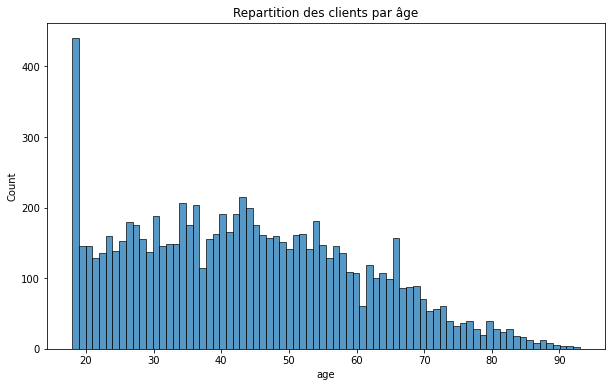

In [107]:
plt.figure(figsize = (10,6))
sns.histplot(customers['age'], bins=customers['age'].nunique())
plt.title('Repartition des clients par âge')

La répartition de la distribution des âges semble "standard", ormis la sur-représentation des individus de 18 ans. Mais, comme il n'y a pas de valeur inférieurs, on peut supposer qu'il s'agit simplement de l'âge minimum pour s'inscrire sur le site.

Observation de la répartition des clients par genre.

In [108]:
genre = customers.groupby(customers['sex'], as_index=False)['client_id'].count()

In [109]:
genre.rename(columns={'client_id':'nombre'},inplace=True)

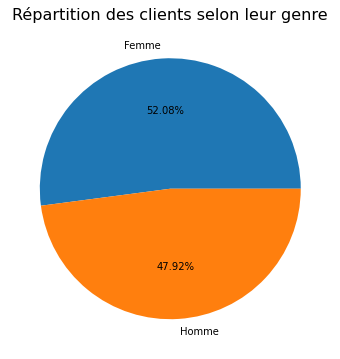

In [110]:
plt.figure(figsize=(10,6))
plt.pie(x=genre['nombre'], autopct = '%1.2f%%', labels = ['Femme', 'Homme'])
plt.title("Répartition des clients selon leur genre", fontsize = 16)
plt.show()

La répartition par genre de la clientèle est très proche de celle de la population française, en effet les femmes représentent 51.6% de la population.

*source: https://www.insee.fr/fr/statistiques/4238375?sommaire=4238781#:~:text=Au%201er%20janvier%202019,24%20ans%20(figure%201).*

#### Etude du chiffre d'affaire par clients et par catégorie

Dans cette partie, nous allons comparer le comportement des différents "segments" de clients par rapport à leurs achats en fonction des catégories.

In [111]:
clients_ca = data.copy()
clients_ca = clients_ca.drop(liste_index_clients_pro, axis=0)

In [112]:
# Déterminer par client le total de dépense par catégorie
clients_ca = clients_ca.groupby(['client_id','categ'], as_index=False).agg({'segment':'first','sex':'first', 'price':'sum'})

In [113]:
clients_ca = clients_ca.sort_values('segment')

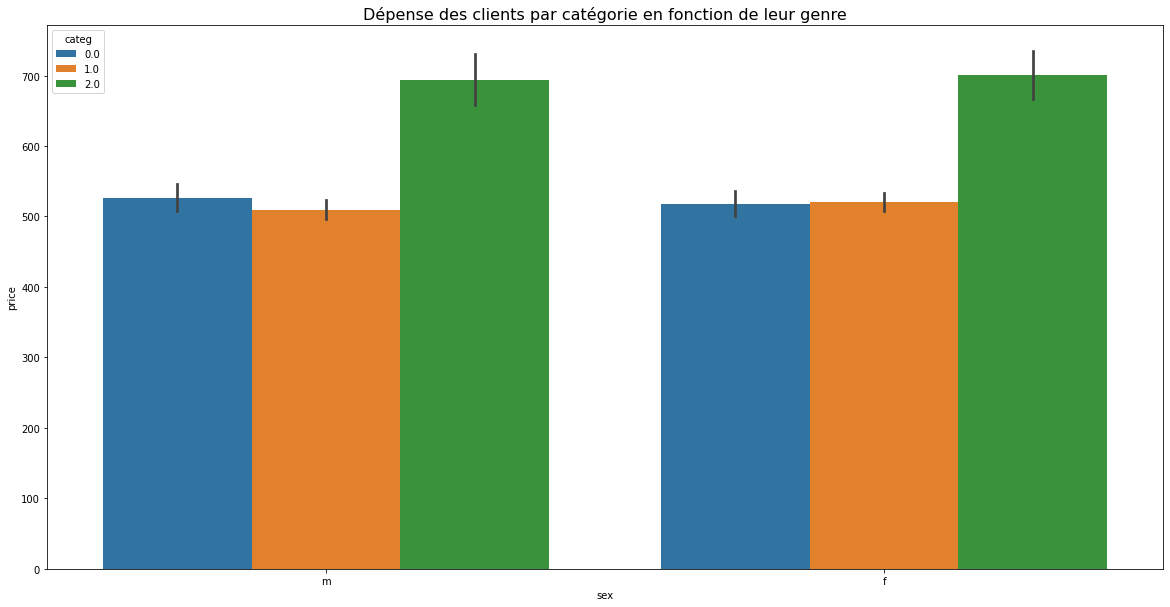

In [114]:
plt.figure(figsize=(20,10))
sns.barplot(data=clients_ca, x = 'sex', y ='price', hue='categ')
plt.title('Dépense des clients par catégorie en fonction de leur genre', fontsize = 16)
plt.show()

Il semblerait que le sexe du client n'a pas d'impact sur le montant dépensé par catégorie. Nous confirmerons cette observation un peu plus loin.

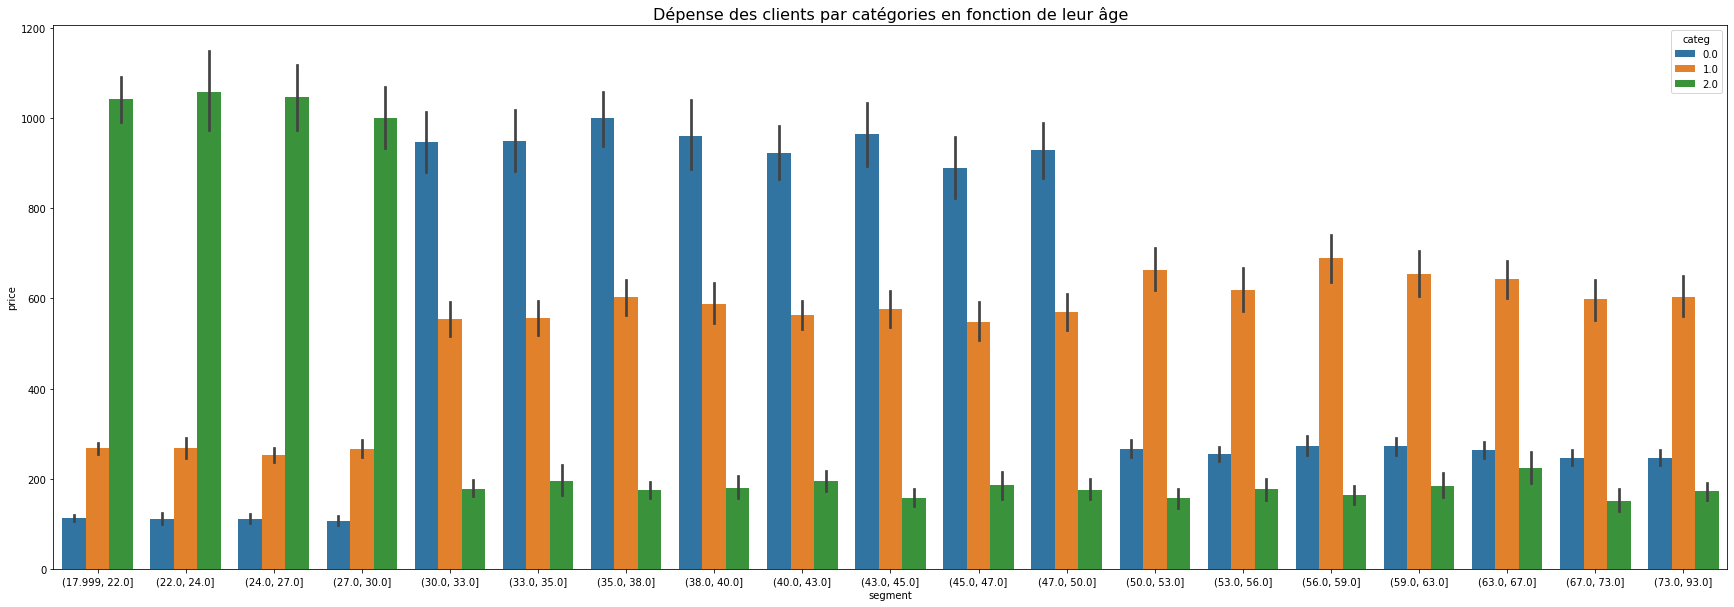

In [115]:
plt.figure(figsize=(30,10))
sns.barplot(data=clients_ca, x = 'segment', y ='price', hue='categ')
plt.title('Dépense des clients par catégories en fonction de leur âge', fontsize = 16)
plt.show()

Il semblerait que l'âge du client influe de manière importante sur ses dépenses par catégorie, nous allons étudier plus en détail le lien entre ces variables.

##### Lien entre le montant total de dépense du client et son âge.

L'objectif de cette partie est de déterminer si l'âge du client a une influence sur le montant total de ses dépenses.

In [116]:
age = data.copy()

In [117]:
age = age.drop(liste_index_clients_pro, axis=0)

In [118]:
# Déterminer les dépenses totales par client
age = age.groupby('client_id', as_index=False).agg({'age':'first','sex':'first', 'price':'sum'})

In [119]:
# Déterminer la dépense moyenne en fonction de l'âge et du sexe du client
age = age.groupby(['age', 'sex'], as_index = False)['price'].mean()

In [120]:
age.head()

,age,sex,price
0,18,f,1356.640433
1,18,m,1435.095874
2,19,f,1208.970462
3,19,m,1245.158750
4,20,f,1206.434000


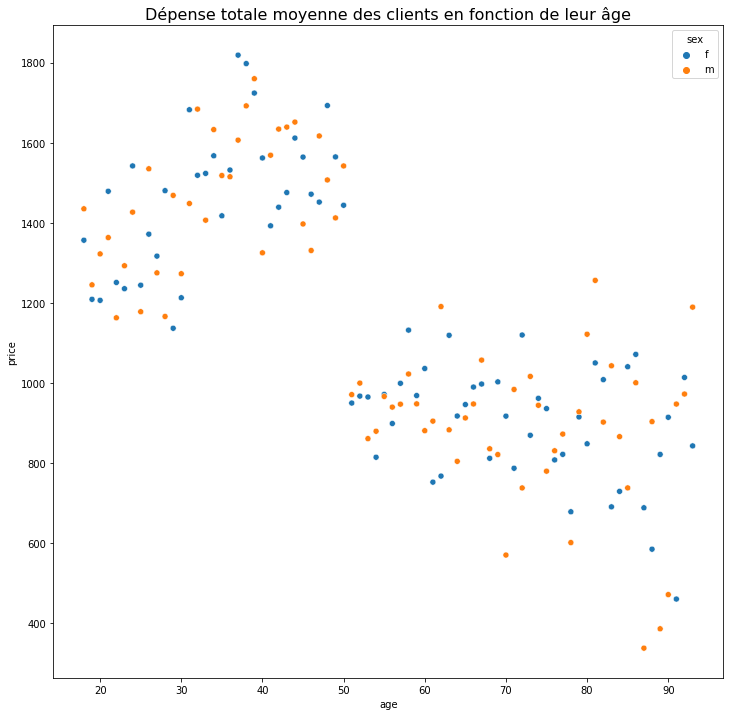

In [121]:
plt.figure(figsize = (12,12))
sns.scatterplot(data=age, x= 'age', y = 'price', hue = 'sex')
plt.title("Dépense totale moyenne des clients en fonction de leur âge", fontsize = 16)
plt.show()

In [122]:
# Utilisation de la méthode 'spearman' car l'âge est une valeur discrète, la correlation de pearson n'est donc pas applicable.
print(age['age'].corr(age["price"], method = 'spearman'))

-0.7230699320482288


Nous constatons une corrélation inverse importante entre l'âge du client et le montant total moyen des achats.

##### Lien entre la dépense totale par catégorie et l'âge du client.

Ici nous allons étudier si une correlation existe entre l'âge du client et le montant dépensé par catégorie.

In [123]:
depense_categ = data.drop(liste_index_clients_pro, axis=0).copy()
depense_categ = depense_categ.groupby(['client_id', 'categ'], as_index= False).agg({'age':'first','price':'sum'})

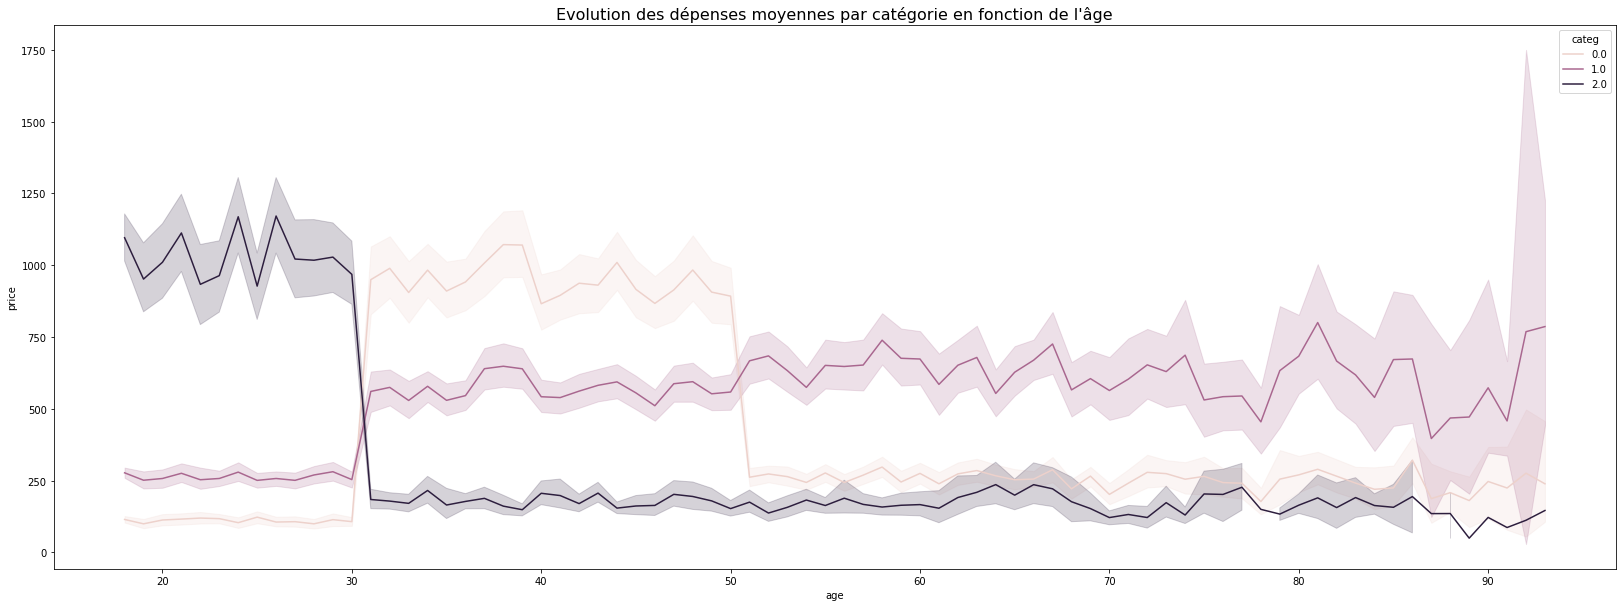

In [124]:
plt.figure(figsize=(28,10))
sns.lineplot(data=depense_categ, x='age',y='price',hue='categ')
plt.title("Evolution des dépenses moyennes par catégorie en fonction de l'âge", fontsize= 16)
plt.show()

On constate que les clients ne concentrent pas leurs dépenses sur les mêmes produits:
- les moins de 30 ans concentrent la majorité de leurs dépenses sur la catégoire 2. 
- à partir de 30 ans les clients ne réalisent presque plus de dépense dans la catégorie 2
- les 30-50 ans réalisent la majorité de leurs dépenses dans la catégorie 0, et une proportion plus réduite dans la catégorie 1
- au-delà de 50 ans les dépenses dans la catégorie 0 baissent fortement, les dépenses des autres catégories restent stables, la catégorie 1 devient le principal poste de dépenses. De ce fait, les dépenses moyennes baissent à partir de cet âge.

#### Lien entre le genre du client et le nombre d'achats par categorie.

Pour éviter que la variabilité des prix entre les catégories n'impacte l'analyse, cette dernière va être réalisée en comparant le nombre de produit acheté par catégorie en fonction de l'âge.

In [125]:
clients_categ = data.copy()
clients_categ = clients_categ.drop(liste_index_clients_pro, axis=0)

In [126]:
# Nombre d'achat par client en fonction de la catégorie
clients_categ = clients_categ.groupby(['client_id','sex','segment','categ'])['price'].count().reset_index()

In [127]:
clients_categ.rename(columns={'price':'nombre'}, inplace = True)

In [128]:
clients_categ = clients_categ.sort_values('segment')

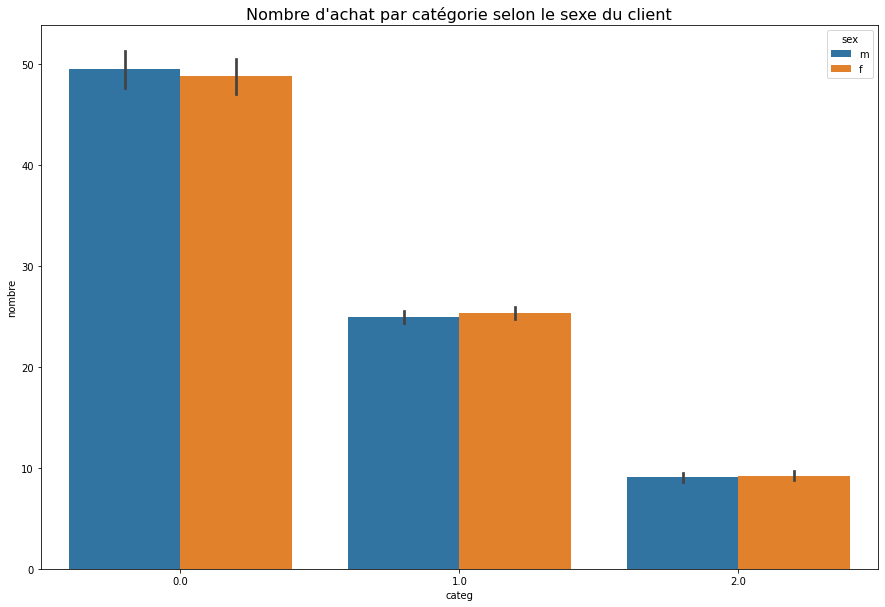

In [129]:
plt.figure(figsize=(15,10))
sns.barplot(data = clients_categ, x='categ', y ='nombre', hue='sex')
plt.title("Nombre d'achat par catégorie selon le sexe du client", fontsize = 16)
plt.show()

##### Vérifier si le genre du client et la catégorie achetée sont deux valeurs indépendantes :Test chi-2

In [130]:
clients_categ.head()

,client_id,sex,segment,categ,nombre
31,c_101,m,"(17.999, 22.0]",0.0,7
32,c_101,m,"(17.999, 22.0]",1.0,7
33,c_101,m,"(17.999, 22.0]",2.0,4
95,c_1033,f,"(17.999, 22.0]",1.0,1
96,c_1033,f,"(17.999, 22.0]",2.0,9


Création de la matrice des fréquences observées:

In [131]:
frequence_obs = clients_categ.pivot_table(index = 'categ', columns = 'sex', values='nombre', aggfunc= 'sum')

In [132]:
display(frequence_obs)

sex,f,m
categ,,
0.0,200904,186589
1.0,111331,101017
2.0,16980,15868


Le but est de déterminer, avec un degré de précision à plus de 95% si le genre du client détermine la catégorie qu'il achète.

In [133]:
from scipy.stats import chi2_contingency as chi2_contingency
khi2, pval , ddl , contingent_theorique = chi2_contingency(frequence_obs)

In [134]:
print(ddl)

2


In [135]:
print(khi2)

20.200173796862927


Pour un degré de liberté de 2 et une précision à 0.05, les variables sont considérées comme indépendantes si le Chi-2 est inférieur à 5.991. Or notre Chi-2 est >20, il y a donc une dépendance entre les variables.

In [136]:
print(pval)

4.1075985631484716e-05


La p-value est inférieure à 0.05, le Chi-2 est donc stastistiquement significatif.

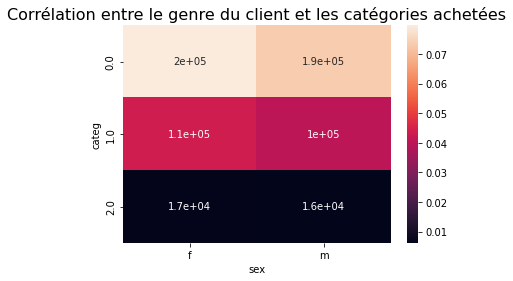

In [137]:
# Création Heatmap contingence

# Céation de la table de fréquences observées avec colonnes de total
frequence_obs = clients_categ.pivot_table(index = 'categ', columns = 'sex', values='nombre', aggfunc= 'sum', margins =True, margins_name='Total')

# Création de la matrice de fréquence théorique
tx = frequence_obs.loc[:,['Total']]
ty = frequence_obs.loc[['Total'],:]
n = len(frequence_obs)
frequence_th = tx.dot(ty)/n

# Création du tableau de Chi-2
temp = (frequence_obs-frequence_th)**2/frequence_th
xi = temp.sum().sum()
chi_2 = temp/xi

# Creation du graphique
sns.heatmap(chi_2.iloc[:-1,:-1],annot=frequence_obs.iloc[:-1,:-1])
plt.title('Corrélation entre le genre du client et les catégories achetées', fontsize = 16)
plt.show()

Le test chi2 nous confirme qu'il y a une différence statistiquement significative entre le nombre d'achats réalisé par les femmes et par les hommes. Pour chaque catégories les femmes achètent plus de produits que les hommes. Il reste à calculer cet écart:

In [138]:
print("Les femmes achètent en moyenne",(frequence_obs.iloc[0,0]/genre.iloc[0]['nombre']/ frequence_obs.iloc[0,1]/genre.iloc[1]['nombre']),' de plus de produits de la catégorie 0 que les hommes')

Les femmes achètent en moyenne 5.8022866253050054e-08  de plus de produits de la catégorie 0 que les hommes


In [139]:
print("Les femmes achètent en moyenne",(frequence_obs.iloc[1,0]/genre.iloc[0]['nombre']/ frequence_obs.iloc[1,1]/genre.iloc[1]['nombre']),' de plus de produits de la catégorie 1 que les hommes')

Les femmes achètent en moyenne 5.939067693626e-08  de plus de produits de la catégorie 1 que les hommes


In [140]:
print("Les femmes achètent en moyenne",(frequence_obs.iloc[2,0]/genre.iloc[0]['nombre']/ frequence_obs.iloc[2,1]/genre.iloc[1]['nombre']),'de plus de produits de la catégorie 2 que les hommes')

Les femmes achètent en moyenne 5.766497740526354e-08 de plus de produits de la catégorie 2 que les hommes


On constate donc qu'il y a une différence statistiquement significative entre le comportement d'achat des femmes et des hommes, en revanche cet écart de comportement est tellement faible qu'il est négligeable.

# Conclusion : Segmentation des clients

Au vue du résultat de l'analyse par client, il semble pertinent de segmenter les clients en trois catégories:
- 18 - 30 ans = A
- 30 - 50 ans = B
- 50+ ans = C

En revanche le genre du client ne semble pas avoir d'influence sur le comportement. 



In [141]:
segmentation = data.drop(liste_index_clients_pro, axis=0).copy()

Pour pouvoir calculer le panier moyen et la fréquence d'achat d'un client nous allons nous allons simplement compter à combien de dates différentes le client a réalisé des achats. 

In [142]:
segmentation = segmentation.groupby('client_id', as_index =False).agg({'age':'first',"sex":"first",'date':'count','price':'sum'})

In [143]:
# création des "catégories" de clientèle
for i in range(len(segmentation['client_id'])):
    if segmentation['age'].iloc[i] <=30:
      x = 'A'
    elif segmentation['age'].iloc[i] <=50:
      x = 'B'
    else:
      x = 'C'
    #colonne a vérifier après le groupement
    segmentation.iloc[i,1] = x

In [144]:
# ajout de la colonne panier moyen
segmentation['panier_moyen'] = round(segmentation['price']/segmentation['date'],2)

Etude de la clientèle par segment:

In [145]:
segmentation_ca = segmentation.groupby('age')['price'].sum().reset_index()

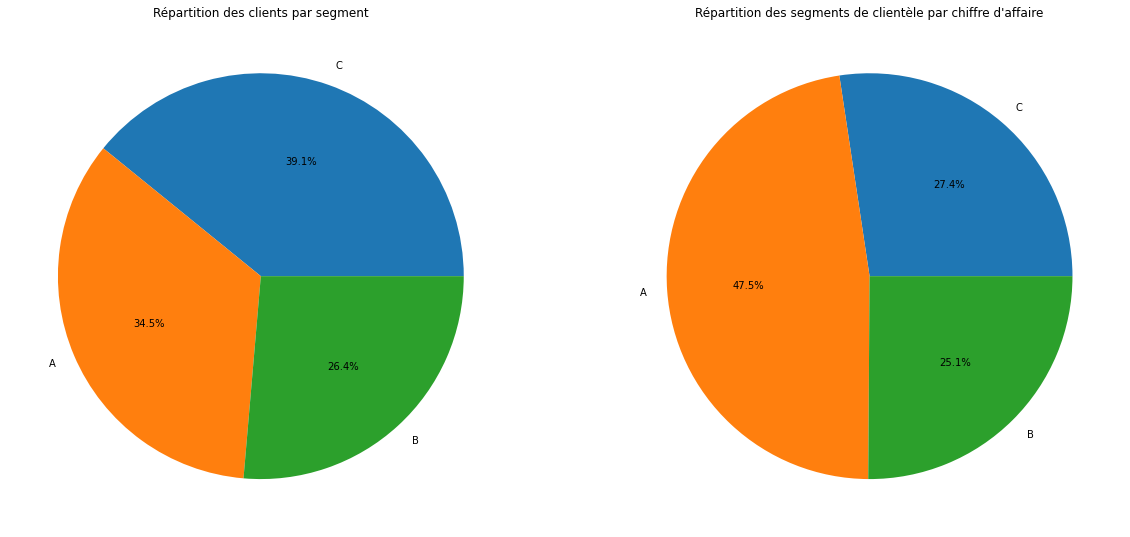

In [146]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.pie(x= segmentation['age'].value_counts(), autopct="%.1f%%", labels=segmentation['age'].unique())
plt.title('Répartition des clients par segment')
plt.subplot(1,2,2)
plt.pie(x= segmentation_ca['price'], autopct="%.1f%%", labels=segmentation['age'].unique())
plt.title("Répartition des segments de clientèle par chiffre d'affaire")
plt.show()

On constate que la clientèle est majoritairement composée de la catégorie C, suivie de près par la catégorie A. La catégorie B est en revanche moins représentée, ce qui est logique car s'il on prend en compte la sur-représentation des individus de 18 ans (correspondant probablement aux clients entre 0-18 ans) la catégorie B est le segment le plus restreint.

En revanche en terme de chiffre d'affaire la catégorie A représente presque la moitié des ventes et la catégorie C et B ont un poids relativement proche malgré la différence de représentation entre les catégorie.

## Etude par segment de clientèle

En plus du DF "segmentation" il est également nécessaire d'étudier pour chaque segment de clientèle les achats par catégorie pour avoir une bonne représentation de leur comportement.

In [147]:
segmentation_categ = data.drop(liste_index_clients_pro, axis=0).copy()

In [148]:
segmentation_categ = segmentation_categ.groupby(['client_id','categ'], as_index = False).agg({"age":"first","price":"sum"})

In [149]:
# création des "catégories" de clientèle
for i in range(len(segmentation_categ['client_id'])):
    if segmentation_categ['age'].iloc[i] <=30:
      x = 'A'
    elif segmentation_categ['age'].iloc[i] <=50:
      x = 'B'
    else:
      x = 'C'
    #colonne a vérifier après le groupement
    segmentation_categ.iloc[i,2] = x

Nous allons effectuer des calculs de moyennes sur les varibales "panier_moyen" et "date" (pour déterminer la fréquence d'achats). Pour vérifier la précision de ces calculs nous allons calculer l'intervalle de confiance pour ces moyennes.

Pour connaître la méthode de calcul à appliquer pour estimer l'intervalle de confiance il convient de vérifier si ces deux variables suivent une loi normale:

In [150]:
# D'Agostino and Pearson's Test
from scipy.stats import normaltest

stat, p = normaltest(segmentation['panier_moyen'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interprétation
alpha = 0.05
if p > alpha:
  print("La variable panier_moyen suit une distribution gaussienne")
else:
  print("La variable panier_moyen ne suit pas une distribution gaussienne")

Statistics=4435.886, p=0.000
La variable panier_moyen ne suit pas une distribution gaussienne


In [151]:
# D'Agostino and Pearson's Test
from scipy.stats import normaltest

stat, p = normaltest(segmentation['date'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interprétation
alpha = 0.05
if p > alpha:
  print("La variable data suit une distribution gaussienne")
else:
  print("La variable date ne suit pas une distribution gaussienne")

Statistics=2829.664, p=0.000
La variable date ne suit pas une distribution gaussienne


Les deux variables ne suivent pas une distribution normale, les intervalles de confiance seront donc calculé via la méthode "bootstrap".

Création des DF par segment de clientèle:

In [152]:
segmentation_A = segmentation.loc[segmentation['age'] == "A",:]
segmentation_categ_A = segmentation_categ.loc[segmentation_categ['age'] == "A",:]
segmentation_B = segmentation.loc[segmentation['age'] == "B",:]
segmentation_categ_B = segmentation_categ.loc[segmentation_categ['age'] == "B",:]
segmentation_C = segmentation.loc[segmentation['age'] == "C",:]
segmentation_categ_C = segmentation_categ.loc[segmentation_categ['age'] == "C",:]

### Calucls des intervalles de confiances.

In [153]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

Catégorie A:

In [154]:
# Intervalle de confiance pour le nombre d'achat

x = segmentation_A['date']
  
# configuration du  bootstrap
n_iterations = 1000 
n_size = int(len(x))
  
# exécution bootstrap
moyennes = list()
for i in range(n_iterations):
   s = resample(x, n_samples=n_size);
   m = np.mean(s);
   moyennes.append(m)

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower =  round(np.percentile(moyennes, p),2)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper =  round(np.percentile(moyennes, p),2)
  
print(f"Le nombre d'achats pour les clients de la catégorie A est compris entre {lower} et {upper} avec une précision de {alpha*100}%")

Le nombre d'achats pour les clients de la catégorie A est compris entre 32.07 et 33.81 avec une précision de 95.0%


In [155]:
# calculer l'intervalle de confiance du panier moyen

x = segmentation_A['panier_moyen']
  
# configuration du bootstrap
n_iterations = 1000 
n_size = int(len(x))
  
# exécution bootstrap
moyennes = list()
for i in range(n_iterations):
   s = resample(x, n_samples=n_size);
   m = np.mean(s);
   moyennes.append(m)

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower =  round(np.percentile(moyennes, p),2)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper =  round(np.percentile(moyennes, p),2)
  
print(f"Le panier moyen pour les clients de la catégorie A est compris entre {lower} et {upper} avec une précision de {alpha*100}%")


Le panier moyen pour les clients de la catégorie A est compris entre 41.13 et 42.54 avec une précision de 95.0%


Catégorie B:

In [156]:
# Intervalle de confiance pour le nombre d'achat

x = segmentation_B['date']
  
# configuration du  bootstrap
n_iterations = 1000 
n_size = int(len(x))
  
# exécution bootstrap
moyennes = list()
for i in range(n_iterations):
   s = resample(x, n_samples=n_size);
   m = np.mean(s);
   moyennes.append(m)

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower =  round(np.percentile(moyennes, p),2)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper =  round(np.percentile(moyennes, p),2)
  
print(f"Le nombre d'achats pour les clients de la catégorie B est compris entre {lower} et {upper} avec une précision de {alpha*100}%")

Le nombre d'achats pour les clients de la catégorie B est compris entre 114.17 et 119.98 avec une précision de 95.0%


In [157]:
# calculer l'intervalle de confiance du panier moyen

x = segmentation_B['panier_moyen']
  
# configuration du bootstrap
n_iterations = 1000 
n_size = int(len(x))
  
# exécution bootstrap
moyennes = list()
for i in range(n_iterations):
   s = resample(x, n_samples=n_size);
   m = np.mean(s);
   moyennes.append(m)

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower =  round(np.percentile(moyennes, p),2)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper =  round(np.percentile(moyennes, p),2)
  
print(f"Le panier moyen pour les clients de la catégorie B est compris entre {lower} et {upper} avec une précision de {alpha*100}%")


Le panier moyen pour les clients de la catégorie B est compris entre 13.31 et 13.43 avec une précision de 95.0%


Catégorie C:

In [158]:
# Intervalle de confiance pour le nombre d'achat

x = segmentation_C['date']
  
# configuration du  bootstrap
n_iterations = 1000 
n_size = int(len(x))
  
# exécution bootstrap
moyennes = list()
for i in range(n_iterations):
   s = resample(x, n_samples=n_size);
   m = np.mean(s);
   moyennes.append(m)

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower =  round(np.percentile(moyennes, p),2)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper =  round(np.percentile(moyennes, p),2)
  
print(f"Le nombre d'achats pour les clients de la catégorie C est compris entre {lower} et {upper} avec une précision de {alpha*100}%")

Le nombre d'achats pour les clients de la catégorie C est compris entre 53.88 et 56.79 avec une précision de 95.0%


In [159]:
# calculer l'intervalle de confiance du panier moyen

x = segmentation_C['panier_moyen']
  
# configuration du bootstrap
n_iterations = 1000 
n_size = int(len(x))
  
# exécution bootstrap
moyennes = list()
for i in range(n_iterations):
   s = resample(x, n_samples=n_size);
   m = np.mean(s);
   moyennes.append(m)

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower =  round(np.percentile(moyennes, p),2)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper =  round(np.percentile(moyennes, p),2)
  
print(f"Le panier moyen pour les clients de la catégorie C est compris entre {lower} et {upper} avec une précision de {alpha*100}%")


Le panier moyen pour les clients de la catégorie C est compris entre 16.59 et 16.82 avec une précision de 95.0%


Nous constatons que les intervalles de confiance pour les deux moyennes, dans chaque segment de clientèle, sont très ressérés, nous pouvons donc condidérer qu'ici la moyenne constitue une aproximation suffisamment fiable pour être utilisée en tant que telle.

### Description des différents segments de clientèle

Catégorie A:

In [160]:
segmentation_categ_A_ca = segmentation_categ_A.groupby('categ')['price'].sum().reset_index()

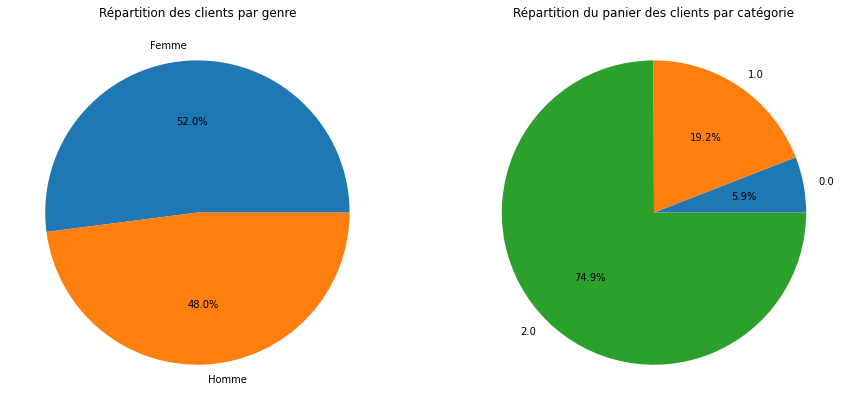

Le panier moyen d'un client de catégorie A est d'un montant de 41.83 €, il a réalisé en moyenne 32.9 achats, soit 1.4 achats par mois


In [161]:
plt.figure(figsize=(15,8))
# Répartition par genre de la catégorie
plt.subplot(1,2,1)
plt.pie(x= segmentation_A['sex'].value_counts(), autopct="%.1f%%", labels=["Femme","Homme"])
plt.title('Répartition des clients par genre')
# Répartition des achats des clients par catégorie de produit
plt.subplot(1,2,2)
plt.pie(x= segmentation_categ_A_ca['price'], autopct="%.1f%%", labels=segmentation_categ_A_ca['categ'].unique())
plt.title("Répartition du panier des clients par catégorie")
plt.show()
print("Le panier moyen d'un client de catégorie A est d'un montant de", round(segmentation_A['panier_moyen'].mean(),2),"€, il a réalisé en moyenne", round(segmentation_A['date'].mean(),1),"achats, soit",round(segmentation_A['date'].mean()/24,1),"achats par mois")

Catégorie B:

In [162]:
segmentation_categ_B_ca = segmentation_categ_B.groupby('categ')['price'].sum().reset_index()

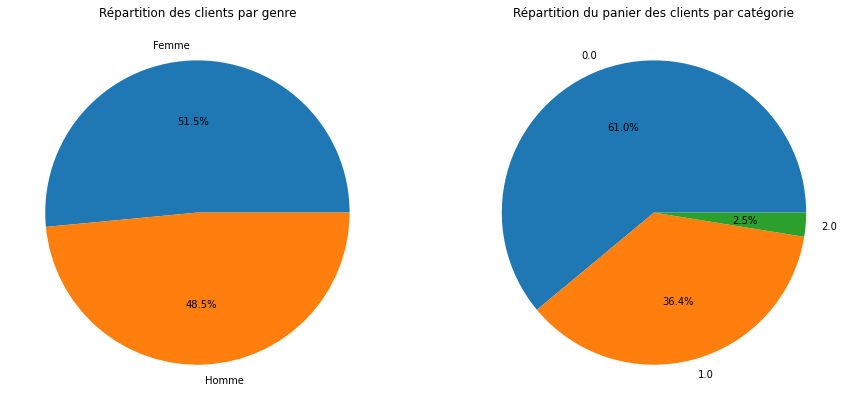

Le panier moyen d'un client de catégorie B est d'un montant de 13.37 €, il a réalisé en moyenne 117.0 achats, soit 4.9 achats par mois


In [163]:
plt.figure(figsize=(15,8))
# Répartition par genre de la catégorie
plt.subplot(1,2,1)
plt.pie(x= segmentation_B['sex'].value_counts(), autopct="%.1f%%", labels=["Femme","Homme"])
plt.title('Répartition des clients par genre')
# Répartition des achats des clients par catégorie de produit
plt.subplot(1,2,2)
plt.pie(x= segmentation_categ_B_ca['price'], autopct="%.1f%%", labels=segmentation_categ_A_ca['categ'].unique())
plt.title("Répartition du panier des clients par catégorie")
plt.show()
print("Le panier moyen d'un client de catégorie B est d'un montant de", round(segmentation_B['panier_moyen'].mean(),2),"€, il a réalisé en moyenne", round(segmentation_B['date'].mean(),1),"achats, soit",round(segmentation_B['date'].mean()/24,1),"achats par mois")

Catégorie C:

In [164]:
segmentation_categ_C_ca = segmentation_categ_C.groupby('categ')['price'].sum().reset_index()

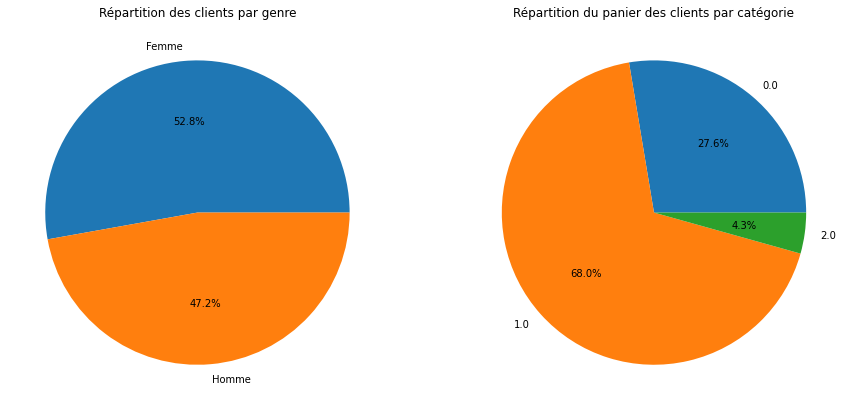

Le panier moyen d'un client de catégorie C est d'un montant de 16.7 €, il a réalisé en moyenne 55.4 achats, soit 2.3 achats par mois


In [165]:
plt.figure(figsize=(15,8))
# Répartition par genre de la catégorie
plt.subplot(1,2,1)
plt.pie(x= segmentation_C['sex'].value_counts(), autopct="%.1f%%", labels=["Femme","Homme"])
plt.title('Répartition des clients par genre')
# Répartition des achats des clients par catégorie de produit
plt.subplot(1,2,2)
plt.pie(x= segmentation_categ_C_ca['price'], autopct="%.1f%%", labels=segmentation_categ_C_ca['categ'].unique())
plt.title("Répartition du panier des clients par catégorie")
plt.show()
print("Le panier moyen d'un client de catégorie C est d'un montant de", round(segmentation_C['panier_moyen'].mean(),2),"€, il a réalisé en moyenne", round(segmentation_C['date'].mean(),1),"achats, soit",round(segmentation_C['date'].mean()/24,1),"achats par mois")